# Part 1: ChIP-Seq (mostly in command line)

Download and generate index for mouse chromosome 19:
`bowtie2-build chr19.fa chr19_index`

#### Map each read:

`
for sample in CTCF_ER4 CTCF_G1E input_ER4 input_G1E
do
    bowtie2 -x chr19_index -U ${sample}.fastq -S ${sample}.sam -p 6 
    samtools view -bSo ${sample}.bam ${sample}.sam
    samtools sort ${sample}.bam -o ${sample}.sorted.bam
    samtools index ${sample}.sorted.bam
done
`


#### Call peaks for CTCF files:

`macs2 callpeak -t CTCF_ER4.bam -c input_ER4.bam --format=BAM --name=CTCF_ER4 --gsize=61000000 --tsize=36`

`macs2 callpeak -t CTCF_G1E.bam -c input_G1E.bam --format=BAM --name=CTCF_G1E --gsize=61000000 --tsize=36`

#### Differential binding of CTCF:

used bedtools intersect and -v flag (based on bedtools documentation) to determine differences between CTCF binding sites by comparing bed files from before (G1E) and after (ER4) differentiation:

`bedtools intersect -a CTCF_G1E_peaks.narrowPeak -b CTCF_ER4_peaks.narrowPeak -v > lost_CTCF.bed`

`bedtools intersect -a CTCF_ER4_peaks.narrowPeak -b CTCF_G1E_peaks.narrowPeak -v > gained_CTCF.bed`

#### Feature overlapping:

download features file:

    `wget https://raw.githubusercontent.com/bxlab/qbb2020/master/week5/Mus_musculus.GRCm38.94_features.bed`

use bedtools intersect again to find overlapping sites:

    `bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b CTCF_G1E_peaks.narrowPeak > features_CTCF_G1E.bed

    bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b CTCF_ER4_peaks.narrowPeak > features_CTCF_ER4.bed`

Count the number of features which overlap with CTCF binding sites by cutting the relevant column from each file:

    `cut -f 4 features_CTCF_G1E.bed | sort | uniq -c > overlap_count_G1E.txt

    cut -f 4 features_CTCF_ER4.bed | sort | uniq -c > overlap_count_ER4.txt`

## Two-panel Bar Plots

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# read counts into pandas dataframe
G1E_counts = pd.read_csv("overlap_count_G1E.txt", sep = "\s+" , names = ["ER4", "region_type"] )
ER4_counts = pd.read_csv("overlap_count_ER4.txt", sep = "\s+", names = ["G1E", "region_type"])

#merge using pandas function
counts = pd.merge(ER4_counts, G1E_counts, on = "region_type")
counts

,G1E,type,ER4
0,101,exon,84
1,341,intron,307
2,67,promoter,54


The left panel should plot the number of CTCF binding sites in each type of region (exon, intron…) for each cell type. The right panel should plot the number of sites lost and gained during differentiation for each cell type.

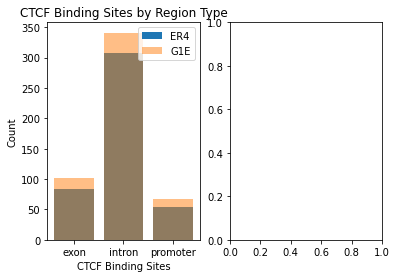

In [12]:
fig, ax = plt.subplots(ncols = 2)

# left panel: number of CTCF binding sites in each region
ax[0].bar(counts.index, counts["ER4"], label = "ER4")
ax[0].bar(counts.index, counts["G1E"], label = "G1E", alpha=0.5)
ax[0].set_title("CTCF Binding Sites by Region Type")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(["exon", "intron", "promoter"])
ax[0].legend()



In [17]:
#use list to count differentiation sites
diff=[]

len_lost = len((open("lost_CTCF.bed")).readlines(  ))
len_gained = len((open("gained_CTCF.bed")).readlines(  ))

diff.append(len_lost)
diff.append(len_gained)

print(diff)

[57, 124]


Text(0.5, 1.0, 'After Differentiation')

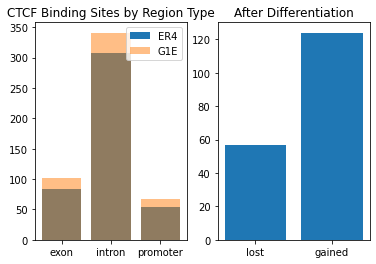

In [19]:
#copy from above for left panel:
fig, ax = plt.subplots(ncols = 2)
ax[0].bar(counts.index, counts["ER4"], label = "ER4")
ax[0].bar(counts.index, counts["G1E"], label = "G1E", alpha=0.5)
ax[0].set_title("CTCF Binding Sites by Region Type")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(["exon", "intron", "promoter"])
ax[0].legend()

# right panel
ax[1].bar(["lost","gained"],diff)
ax[1].set_title("After Differentiation")


# Part 2: Motif Discovery

Prepare meme suite:

    conda install meme -y
    
    wget http://meme-suite.org/meme-software/Databases/motifs/motif_databases.12.19.tgz
    
    tar -xf motif_databases.12.19.tgz

First, find the strongest 100 peaks based on the 9th column for lowest p values:

    `sort -h -r -k 9 CTCF_ER4_peaks.narrowPeak | head-n 100 > strongest100_ER4.txt`

Make a fasta file using chr19 reference out of the strongest peaks file:

    `bedtools getfasta -fi chr19.fa -bed strongest100_ER4.txt > strongest100_ER4.fasta`

Generate motif file with meme-chip:

    `meme-chip  -meme-maxw 20 -oc meme_data strongest100_ER4.fasta`

Scan against the JASPAR_CORE_2019 database using tomtom:

    `tomtom meme_data/combined.meme motif_databases/JASPAR/JASPAR_CORE_2016.meme

The image in the tomtom html file with the lowest p value was pushed to github
